In [120]:
import numpy as np
from matplotlib import pyplot
import json

########## Récupération des valeurs dans les fichiers ##########
datafile = "normal10000.json"
f = open(datafile, "r")
data_train = [json.loads(line) for line in f.readlines()]

datafile = "train_normal800.json"
f = open(datafile, "r")
data_traintest = [json.loads(line) for line in f.readlines()]

datafile = "2abnormal1000.json"
f = open(datafile, "r")
data_test = [json.loads(line) for line in f.readlines()]

f.close()

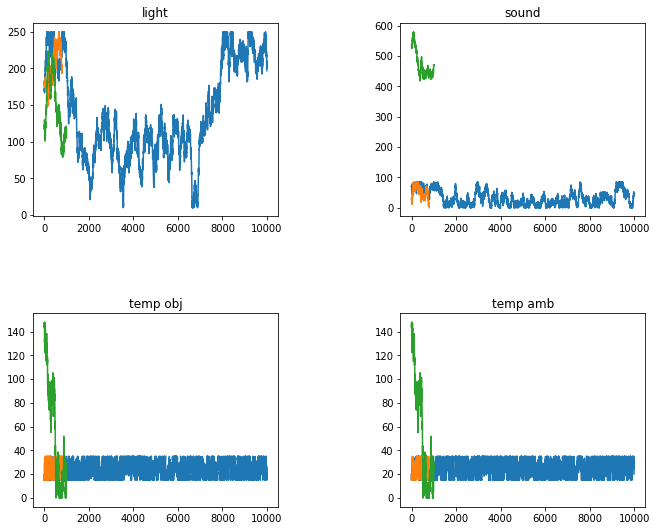

In [121]:
from sklearn.preprocessing import MinMaxScaler
########## Préprocessing des données  ##########

# Lecture des données pour l'apprentissage et création d'une liste pour chaque capteur
list_light, list_sound, list_temp_object, list_temp_ambient = [], [], [], []
for d in data_train:
    list_light.append(d["light"])
    list_sound.append(d["sound"])
    list_temp_object.append(d["temp"]["object"])
    list_temp_ambient.append(d["temp"]["ambient"])

nb_time_stamps = len(data_train)

# Conversion des listes en tableaux numpy
light_train = np.array(list_light)
sound_train = np.array(list_sound)
temp_object_train = np.array(list_temp_object)
temp_ambient_train = np.array(list_temp_ambient)

# Création d'un tableau avec toutes les valeurs
train_values = np.stack((light_train,sound_train,temp_object_train,temp_ambient_train), axis=-1)
#print(train_values)

# Lecture des données pour l'apprentissage et création d'une liste pour chaque capteur
list_light, list_sound, list_temp_object, list_temp_ambient = [], [], [], []
for d in data_traintest:
    list_light.append(d["light"])
    list_sound.append(d["sound"])
    list_temp_object.append(d["temp"]["object"])
    list_temp_ambient.append(d["temp"]["ambient"])

# Conversion des listes en tableaux numpy
lt = np.array(list_light)
st = np.array(list_sound)
tot = np.array(list_temp_object)
tat = np.array(list_temp_ambient)

# Création d'un tableau avec toutes les valeurs
traintest_values = np.stack((lt,st,tot,tat), axis=-1)
#print(traintest_values)

########## Préprocessing des données anormales  ##########

# Lecture des données pour l'apprentissage et création d'une liste pour chaque capteur
list_light, list_sound, list_temp_object, list_temp_ambient = [], [], [], []
for d in data_test:
    list_light.append(d["light"])
    list_sound.append(d["sound"])
    list_temp_object.append(d["temp"]["object"])
    list_temp_ambient.append(d["temp"]["ambient"])

# Conversion des listes en tableaux numpy
light_test = np.array(list_light)
sound_test = np.array(list_sound)
temp_object_test = np.array(list_temp_object)
temp_ambient_test = np.array(list_temp_ambient)

# Création d'un tableau avec toutes les valeurs
abno_values = np.stack((light_test,sound_test,temp_object_test,temp_ambient_test), axis=-1)
#print(test_values)

# plot training values
pyplot.figure(1,figsize=(10, 8))

pyplot.subplot(221)
pyplot.plot(light_train)
pyplot.plot(lt)
pyplot.plot(light_test)
pyplot.title("light")

pyplot.subplot(222)
pyplot.plot(sound_train)
pyplot.plot(st)
pyplot.plot(sound_test)
pyplot.title("sound")

pyplot.subplot(223)
pyplot.plot(temp_object_train)
pyplot.plot(tot)
pyplot.plot(temp_object_test)
pyplot.title("temp obj")

pyplot.subplot(224)
pyplot.plot(temp_ambient_train)
pyplot.plot(tat)
pyplot.plot(temp_object_test)
pyplot.title("temp amb")

pyplot.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.5)
pyplot.show()

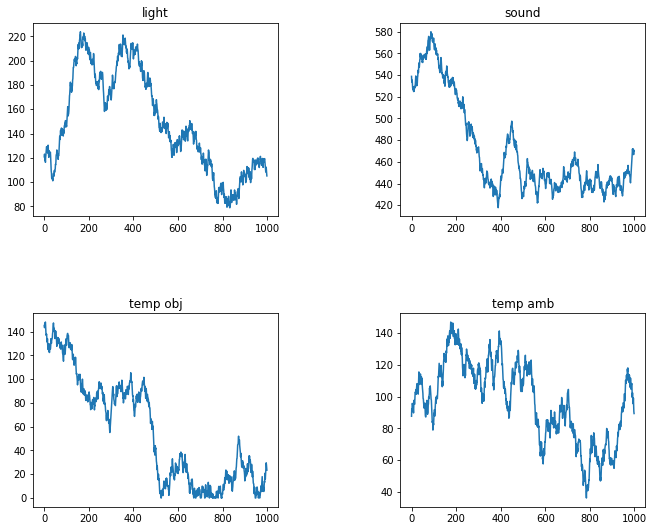

In [122]:
########## Préprocessing des données anormales  ##########

# Lecture des données pour l'apprentissage et création d'une liste pour chaque capteur
list_light, list_sound, list_temp_object, list_temp_ambient = [], [], [], []
for d in data_test:
    list_light.append(d["light"])
    list_sound.append(d["sound"])
    list_temp_object.append(d["temp"]["object"])
    list_temp_ambient.append(d["temp"]["ambient"])

# Conversion des listes en tableaux numpy
light_test = np.array(list_light)
sound_test = np.array(list_sound)
temp_object_test = np.array(list_temp_object)
temp_ambient_test = np.array(list_temp_ambient)

# Création d'un tableau avec toutes les valeurs
abno_values = np.stack((light_test,sound_test,temp_object_test,temp_ambient_test), axis=-1)
#print(test_values)

# plot training values
pyplot.figure(1,figsize=(10, 8))

pyplot.subplot(221)
pyplot.plot(light_test)
pyplot.title("light")

pyplot.subplot(222)
pyplot.plot(sound_test)
pyplot.title("sound")

pyplot.subplot(223)
pyplot.plot(temp_object_test)
pyplot.title("temp obj")

pyplot.subplot(224)
pyplot.plot(temp_ambient_test)
pyplot.title("temp amb")

pyplot.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.5)
pyplot.show()

In [123]:
# Normalisation
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_values)
scaled_test = scaler.fit_transform(traintest_values)
print(scaled_train.shape)

(10000, 4)


In [124]:
from pandas import DataFrame
from pandas import concat

# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [125]:
# frame as supervised learning
reframed_train = series_to_supervised(scaled_train, 1, 1)
reframed_test = series_to_supervised(scaled_test, 1, 1)
print(reframed_train.head())
print(reframed_train.shape)
print(reframed_train.values)

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)   var2(t)   var3(t)  \
1   0.666565   0.826334   0.000000   0.000000  0.663742  0.790094  0.000000   
2   0.663742   0.790094   0.000000   0.185837  0.669603  0.845614  0.127610   
3   0.669603   0.845614   0.127610   0.303683  0.677580  0.826474  0.037268   
4   0.677580   0.826474   0.037268   0.158902  0.678778  0.805218  0.000000   
5   0.678778   0.805218   0.000000   0.169426  0.669721  0.837741  0.001797   

    var4(t)  
1  0.185837  
2  0.303683  
3  0.158902  
4  0.169426  
5  0.000000  
(9999, 8)
[[0.66656497 0.82633447 0.         ... 0.79009401 0.         0.18583738]
 [0.66374159 0.79009401 0.         ... 0.84561436 0.12761041 0.30368281]
 [0.66960285 0.84561436 0.12761041 ... 0.82647392 0.03726843 0.15890177]
 ...
 [0.82202566 0.5422585  0.         ... 0.49160846 0.         0.65388323]
 [0.80145905 0.49160846 0.         ... 0.52505285 0.12996253 0.44167519]
 [0.79125357 0.52505285 0.12996253 ... 0.51404157 0.28680457 

In [126]:
# split into train and test sets
#values = reframed.values
#n_train_values = 800
#train = values[:n_train_values, :]
#test = values[n_train_values:, :]
train = reframed_train.values
test = reframed_test.values
print(train.shape)
print(test.shape)
# split into input and outputs
train_X, train_y = train[:, :-4], train[:, 4:]
test_X, test_y = test[:, :-4], test[:, 4:]
#train_X, train_y = train[:, :-4], train[:, 20:]
#test_X, test_y = test[:, :-4], test[:, 20:]
print(test_X.shape)
print(test_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(9999, 8)
(799, 8)
(799, 4)
(799, 4)
(9999, 1, 4) (9999, 4) (799, 1, 4) (799, 4)


Train on 9999 samples, validate on 799 samples
Epoch 1/50
 - 4s - loss: 0.2515 - val_loss: 0.1993
Epoch 2/50
 - 1s - loss: 0.1365 - val_loss: 0.1222
Epoch 3/50
 - 1s - loss: 0.0838 - val_loss: 0.0958
Epoch 4/50
 - 1s - loss: 0.0729 - val_loss: 0.0863
Epoch 5/50
 - 1s - loss: 0.0697 - val_loss: 0.0799
Epoch 6/50
 - 1s - loss: 0.0672 - val_loss: 0.0742
Epoch 7/50
 - 1s - loss: 0.0658 - val_loss: 0.0715
Epoch 8/50
 - 1s - loss: 0.0652 - val_loss: 0.0708
Epoch 9/50
 - 1s - loss: 0.0647 - val_loss: 0.0706
Epoch 10/50
 - 1s - loss: 0.0644 - val_loss: 0.0704
Epoch 11/50
 - 1s - loss: 0.0643 - val_loss: 0.0703
Epoch 12/50
 - 1s - loss: 0.0642 - val_loss: 0.0703
Epoch 13/50
 - 1s - loss: 0.0641 - val_loss: 0.0704
Epoch 14/50
 - 1s - loss: 0.0641 - val_loss: 0.0702
Epoch 15/50
 - 1s - loss: 0.0641 - val_loss: 0.0703
Epoch 16/50
 - 1s - loss: 0.0640 - val_loss: 0.0706
Epoch 17/50
 - 1s - loss: 0.0640 - val_loss: 0.0705
Epoch 18/50
 - 1s - loss: 0.0640 - val_loss: 0.0708
Epoch 19/50
 - 1s - loss: 

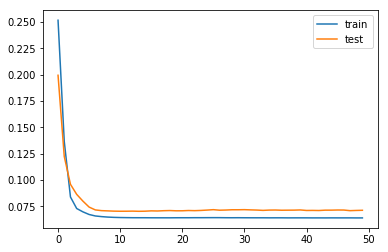

In [127]:
import tensorflow as tf

# design network
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tf.keras.layers.Dense(4))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=30, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [128]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print(yhat.shape)

(799, 4)


(799, 4)
(799, 4)
Test RMSE light: 2.932
Test RMSE sound: 4.375
Test RMSE temp obj: 2.532
Test RMSE temp amb: 2.696


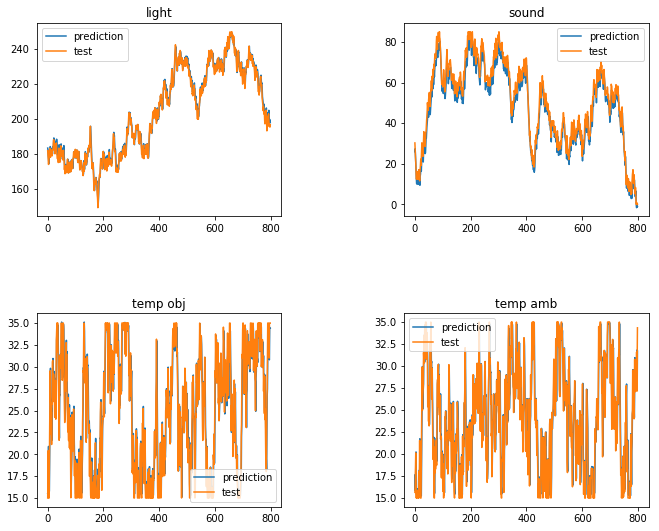

In [129]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# invert scaling for forecast
#inv_yhat = np.concatenate((yhat, test_X[:, 4:]), axis=1)
inv_yhat = scaler.inverse_transform(yhat)
inv_yhat_light = inv_yhat[:,0]
inv_yhat_sound = inv_yhat[:,1]
inv_yhat_to = inv_yhat[:,2]
inv_yhat_ta = inv_yhat[:,3]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 4))
#inv_y = np.concatenate((test_y, test_X[:, 4:]), axis=1)
inv_y = scaler.inverse_transform(test_y)
inv_y_light = inv_y[:,0]
inv_y_sound = inv_y[:,1]
inv_y_to = inv_y[:,2]
inv_y_ta = inv_y[:,3]
#print(inv_y_light)
#print(inv_y_sound)
#print(inv_y_to)
#print(inv_y_ta)

print(inv_y.shape)
print(inv_yhat.shape)

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y_light, inv_yhat_light))
print('Test RMSE light: %.3f' % rmse)
rmse = sqrt(mean_squared_error(inv_y_sound, inv_yhat_sound))
print('Test RMSE sound: %.3f' % rmse)
rmse = sqrt(mean_squared_error(inv_y_to, inv_yhat_to))
print('Test RMSE temp obj: %.3f' % rmse)
rmse = sqrt(mean_squared_error(inv_y_ta, inv_yhat_ta))
print('Test RMSE temp amb: %.3f' % rmse)

# plot predictions
pyplot.figure(1,figsize=(10, 8))

pyplot.subplot(221)
pyplot.plot(inv_yhat_light, label='prediction')
pyplot.plot(inv_y_light, label='test')
pyplot.legend()
pyplot.title("light")

pyplot.subplot(222)
pyplot.plot(inv_yhat_sound, label='prediction')
pyplot.plot(inv_y_sound, label='test')
pyplot.legend()
pyplot.title("sound")

pyplot.subplot(223)
pyplot.plot(inv_yhat_to, label='prediction')
pyplot.plot(inv_y_to, label='test')
pyplot.legend()
pyplot.title("temp obj")

pyplot.subplot(224)
pyplot.plot(inv_yhat_ta, label='prediction')
pyplot.plot(inv_y_ta, label='test')
pyplot.legend()
pyplot.title("temp amb")

pyplot.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.5)
pyplot.show()

In [130]:
# Normalisation
scaler = MinMaxScaler(feature_range=(0, 1))
test_scaled = scaler.fit_transform(abno_values)
print(test_scaled.shape)

(1000, 4)


In [132]:
# frame as supervised learning --> pas nécessaire, besoin seulement d'un shift
test_reframed = series_to_supervised(test_scaled, 1, 1)
print(test_reframed.head())
print(test_reframed.shape)
print(test_reframed.values)

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)   var2(t)   var3(t)  \
1   0.288914   0.746474   0.980536   0.464690  0.304556  0.718178  0.968115   
2   0.304556   0.718178   0.968115   0.506838  0.277849  0.713788  0.991914   
3   0.277849   0.713788   0.991914   0.492660  0.269550  0.725208  0.988970   
4   0.269550   0.725208   0.988970   0.537142  0.271038  0.696066  0.997363   
5   0.271038   0.696066   0.997363   0.534575  0.258060  0.681445  1.000000   

    var4(t)  
1  0.506838  
2  0.492660  
3  0.537142  
4  0.534575  
5  0.533804  
(999, 8)
[[0.28891404 0.74647389 0.98053553 ... 0.71817834 0.96811483 0.50683782]
 [0.30455597 0.71817834 0.96811483 ... 0.71378838 0.9919141  0.49266008]
 [0.27784856 0.71378838 0.9919141  ... 0.72520814 0.98896993 0.53714199]
 ...
 [0.23001657 0.32418035 0.19990473 ... 0.30174456 0.18953681 0.52840496]
 [0.20770689 0.30174456 0.18953681 ... 0.32744788 0.17134566 0.49135316]
 [0.19533332 0.32744788 0.17134566 ... 0.3223774  0.15818172 0

In [133]:
real_values = test_reframed.values
# split into input and outputs
#X, y = real_values[:, :-4], real_values[:, 4:]
X, y = real_values[:, :-4], real_values[:, 4:]
# split input in 10 arrays
#nb_seq = 10
#X = np.array_split(X,nb_seq)
#print(X[0].shape)
# reshape input to be 3D [samples, timesteps, features]
#for i in range(nb_seq):
 #   X[i] = X[i].reshape((X[i].shape[0], 1, X[i].shape[1]))
X = X.reshape((X.shape[0], 1, X.shape[1]))
print(X.shape)
print(y.shape)

(999, 1, 4)
(999, 4)


In [134]:
# make a prediction
#ypred = []
#for i in range(nb_seq):
 #   ypred.append(model.predict(X[i]))
#ypred = np.array(ypred)
#ypred = np.concatenate((ypred))
ypred = model.predict(X)
print(ypred.shape)

(999, 4)


In [135]:
inv_ypred = scaler.inverse_transform(ypred)
inv_ypred_light = inv_ypred[:,0]
inv_ypred_sound = inv_ypred[:,1]
inv_ypred_to = inv_ypred[:,2]
inv_ypred_ta = inv_ypred[:,3]

abno_pred = scaler.inverse_transform(y)
y_light = abno_pred[:,0]
y_sound = abno_pred[:,1]
y_to = abno_pred[:,2]
y_ta = abno_pred[:,3]

In [136]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_ypred_light, y_light))
print('Test RMSE light: %.3f' % rmse)
rmse = sqrt(mean_squared_error(inv_ypred_sound, y_sound))
print('Test RMSE sound: %.3f' % rmse)
rmse = sqrt(mean_squared_error(inv_ypred_to, y_to))
print('Test RMSE temp obj: %.3f' % rmse)
rmse = sqrt(mean_squared_error(inv_ypred_ta, y_ta))
print('Test RMSE temp amb: %.3f' % rmse)

Test RMSE light: 3.220
Test RMSE sound: 5.979
Test RMSE temp obj: 3.964
Test RMSE temp amb: 2.919


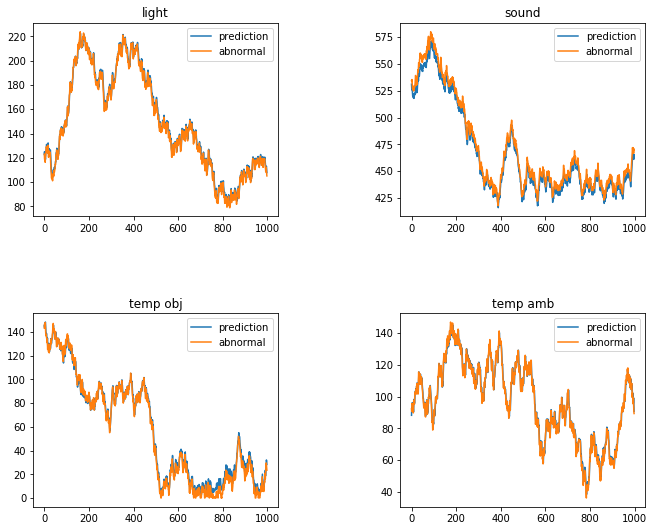

In [137]:
# plot predictions
pyplot.figure(1,figsize=(10, 8))

pyplot.subplot(221)
pyplot.plot(inv_ypred_light, label='prediction')
pyplot.plot(y_light, label='abnormal')
pyplot.legend()
pyplot.title("light")

pyplot.subplot(222)
pyplot.plot(inv_ypred_sound, label='prediction')
pyplot.plot(y_sound, label='abnormal')
pyplot.legend()
pyplot.title("sound")

pyplot.subplot(223)
pyplot.plot(inv_ypred_to, label='prediction')
pyplot.plot(y_to, label='abnormal')
pyplot.legend()
pyplot.title("temp obj")

pyplot.subplot(224)
pyplot.plot(inv_ypred_ta, label='prediction')
pyplot.plot(y_ta, label='abnormal')
pyplot.legend()
pyplot.title("temp amb")

pyplot.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.5)
pyplot.show()